In [1]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

# Import packages and plotting settings

In [58]:
import time, os, pickle, hsluv, warnings
warnings.filterwarnings('ignore')
from glob import glob
import numpy as np
import matplotlib.pyplot as plt
plt.ioff()
%matplotlib inline

from scipy import optimize
from scipy.linalg import lapack
import scipy.stats as st
from scipy.interpolate import interp1d
from scipy.integrate import quad

from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.gaussian_process import GaussianProcessRegressor as GPR
from sklearn.gaussian_process import GaussianProcessRegressor as gpr
from sklearn.gaussian_process import kernels

from pyDOE import lhs
import emcee

import pandas as pd
import seaborn as sns
sns.set_style("ticks")
sns.color_palette('bright')


fontsmall, fontnormal, fontlarge = 8, 10, 12.5
offblack = '#262626'
aspect = 1/1.618
textwidth = 10
textheight = 10

plt.rcdefaults()
plt.rcParams.update({
    'font.family': 'DejaVu Sans-Serif',
    'font.sans-serif': ['Lato'],
    'mathtext.fontset': 'custom',
    'mathtext.default': 'it',
    'mathtext.rm': 'sans',
    'mathtext.it': 'sans:italic:medium',
    'mathtext.cal': 'sans',
    'font.size': fontnormal,
    'legend.fontsize': fontnormal,
    'axes.labelsize': fontnormal,
    'axes.titlesize': fontnormal,
    'xtick.labelsize': fontnormal,
    'ytick.labelsize': fontnormal,
    'lines.linewidth': 1.5,
    'lines.markersize': 5,
    'lines.markeredgewidth': .5,
    'patch.linewidth': 1,
    'hatch.linewidth':1,
    'axes.linewidth': 1,
    'xtick.major.width': 1,
    'ytick.major.width': 1,
    'xtick.minor.width': 1,
    'ytick.minor.width': 1,
    'xtick.major.size': 1.2,
    'ytick.major.size': 1.2,
    'xtick.minor.size': .8,
    'ytick.minor.size': .8,
    'xtick.major.pad': 1.5,
    'ytick.major.pad': 1.5,
    'axes.formatter.limits': (-5, 5),
    'axes.spines.top': True,
    'axes.spines.right': True,
    'ytick.right': True,
    'axes.labelpad': 3,
    'text.color': offblack,
    'axes.edgecolor': offblack,
    'axes.labelcolor': offblack,
    'xtick.color': offblack,
    'ytick.color': offblack,
    'legend.numpoints': 1,
    'legend.scatterpoints': 1,
    'legend.frameon': False,
    'image.cmap': 'Blues',
    'image.interpolation': 'none',
    'pdf.fonttype': 42
})
cm1, cm2 = plt.cm.Blues(.8), plt.cm.Reds(.8)
cb,co,cg,cr,ck = plt.cm.Blues(.6), plt.cm.Oranges(.6), plt.cm.Greens(.6), plt.cm.Reds(.6), '.5'
gray = '0.8'

def darken(rgb, amount=.15):
    #Darken a color by the given amount in HSLuv space.
    h, s, l = hsluv.rgb_to_hsluv(rgb)
    return hsluv.hsluv_to_rgb((h, s, (1 - amount)*l))


# Create directories

In [83]:
print("Current working directory: ", os.getcwd())
Path = os.getcwd()
# Create all directories
# 1. parameter design
design_path = Path + "/Parameters/"
design_file = design_path + "/qhat_design_tables.dat"
os.makedirs(design_path, exist_ok=True)
# 2. create figure folder
fig_path = Path + "/Figures/"
os.makedirs(fig_path, exist_ok=True)
def save_fig(fig_id, tight=True):
    if tight:
        plt.tight_layout(True)
    plt.savefig(fig_path+"/"+fig_id+".png", format='png', dpi=300)

Current working directory:  /home/weiyao/Research/CCNU-PROJ/Clean-up


In [159]:
Model_IAA_Folder = './ModelData/IAA/'
Model_RAA_Folder = './ModelData/RAA/'
Exp_IAA_Folder = './ExpData/IAA/'
Exp_RAA_Folder = './ExpData/RAA/'
if not (os.path.exists(Model_IAA_Folder) and os.path.exists(Model_RAA_Folder)
    and os.path.exists(Exp_IAA_Folder) and os.path.exists(Exp_RAA_Folder)
       ):
    print("Missing data!")
    print("Please make sure you have \n 1) run physics model \n 2) get the exp data \n 3) put them under the indicated folder")

    
StatisticalDataFolder = './Bayesian_analysis_data/'
os.makedirs(StatisticalDataFolder , exist_ok=True)
#emulator file
emulator_file = StatisticalDataFolder +"/emulators.dat"

# Functions to generate random field

1. Gaussian random field is generated with 1D Gaussian process
2. Then, the exponential mapping take the Gaussian random field to a positive definite random field


In [40]:
# Genearte correlated random function as samples of (qhat/T^3)/mean
def Mean_f(x, mean):
    return mean*np.ones_like(x)

# call the Gaussian process to generate 1D random field with given std, correlation length
def Var_f(x, sigma, L, N, random_state):
    kernel = sigma**2 * kernels.RBF(length_scale=L)  
    GP = gpr(kernel=kernel)
    y = GP.sample_y(np.atleast_2d(x).T, n_samples=N, random_state=random_state)
    return y

def Get_f(x, mean, sigma, L, N, random_state):
    # sigma_gaussian
    sigma_gaussian = np.sqrt(np.log(sigma**2+1))
    # get mean
    meanf = Mean_f(x, mean)
    # get Gaussian Varaiton
    varf = Var_f(x, sigma_gaussian, L, N, random_state=random_state)
    # convert Gaussian varation to positive definite log-normal fluctuation
    Pvarf = np.exp(varf-sigma_gaussian**2/2.)
    #print(Pvarf[0].mean(), Pvarf[0].std())
    f = Pvarf.T*meanf
    return f

# Create (or load) the design

In [79]:
# The reference scale is Tref=0.15 GeV ()
Tref = 0.15
# The design will cover Tref to 5*Tref, sufficient for top LHC energy
lnT = np.linspace(np.log(Tref), np.log(5*Tref), 21)
T = np.exp(lnT)
# The mean of the qhats/T3 design
qhatT3_mean = 5.0
# The std of the (qhats/T3)/mean
qhatT3_std = .8 
# The correlation length
Lcorr = np.log(2/1)

# creat a small number of random samples as the design, use a fixed random state!!!
qhatsT3_design = Get_f(lnT, qhatT3_mean, qhatT3_std, Lcorr, 100, random_state=31415)
# and write it to file
with open("Parameters/qhatT3_design_tables.dat", 'w') as f:
    f.write( ("#"+"{:1.5e}\t"*len(T)+"\n").format(*T) )
    for it in qhatsT3_design:
        f.write( ("{:1.5e}\t"*len(T)+"\n").format(*it) )
# or uncomment to load from exisitng file
#qhats = np.loadtxt("Parameters/qhatT3_design_tables.dat")

# creat a large number of random samples to better represent the prior distribution
qhatsT3_prior = Get_f(lnT, qhatT3_mean, qhatT3_std, Lcorr, 100000, random_state=271828)
# check that the mean and std is indeed the same as required
print("Mean of the prior samples = ", np.mean(qhatsT3_prior))
print("Std of the prior samples = ", np.std(qhatsT3_prior)/np.mean(qhatsT3_prior))

Mean of the prior samples =  4.980162732484697
Std of the prior samples =  0.7992800292575326


# Plot the design and demonstrate its property

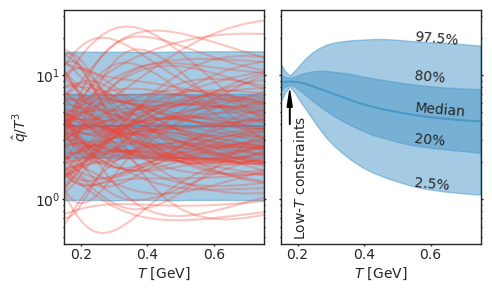

In [137]:
fig, (ax, ax1) = plt.subplots(ncols=2,nrows=1,figsize=(textwidth*.5,textwidth*.3),
                              sharex=True, sharey=True)

# plot the median of qhat prior
ax.plot(T, np.percentile(qhatsT3_prior, 50, axis=0), '-', color=cb, alpha=1)
# plot the 60% and 95% interval of the prior
for interval in [60, 95]:
    ax.fill_between(T, np.percentile(qhatsT3_prior, 50-interval/2, axis=0),
                     np.percentile(qhatsT3_prior, 50+interval/2, axis=0), 
                     color=cb, alpha=.5)

# plot the 100 design
ax.plot(T, qhatsT3_design.T, color=cr, alpha=0.3)

# As a demonstration: plot a restrictive prior with qhat/T3 at T=T[2] contrained between 8 to 10
iT = 2
cut = (8<qhatsT3_prior[:,iT]) & (qhatsT3_prior[:,iT]<10)
# plot the median of qhat prior
ax1.plot(T, np.percentile(qhatsT3_prior[cut], 50, axis=0), '-', color=cb, alpha=1)
# plot the 60% and 95% interval of the prior
for interval in [60, 95]:
    ax1.fill_between(T, np.percentile(qhatsT3_prior[cut], 50-interval/2, axis=0),
                     np.percentile(qhatsT3_prior[cut], 50+interval/2, axis=0), 
                     color=cb, alpha=.5)

ax.set_xlim(0.15,.75)
ax1.arrow(T[2],4,0,1.5, head_width=.015, head_length=2, color='k')
ax1.annotate("Low-$T$ constraints", xy=(.185,.5), rotation=90)
ax1.annotate("Median", xy=(.55,4.7), rotation=-5)
ax1.annotate("80%", xy=(.55,4.7+4), rotation=-5)
ax1.annotate("20%", xy=(.55,4.7-2), rotation=-5)
ax1.annotate("97.5%", xy=(.55,4.7+13), rotation=-5)
ax1.annotate("2.5%", xy=(.55,4.7-3.5), rotation=-5)
#ax.set_ylim(0,20)

ax.set_xlabel(r"$T$ [GeV]")
ax1.set_xlabel(r"$T$ [GeV]")
ax.set_ylabel(r"$\hat{q}/T^3$")
ax.semilogy()
plt.tight_layout()
save_fig("1_Prior_and_design")

# Now use these qhats to compute physical observable
This is not part of the statistics program

# Load experimental data and select a subset for Bayesian analysis
For example, we take only gamma-hadron, di-hadron and single-hadron data below 50% centrality. We did not take hadron-jet correlation and peripheral data.
There is also a pT cut to ensure the perturbative production mechanism.

In [138]:
pTlow, pThigh = 8, 100

Obs = ['AuAu200-g-h',
       'AuAu200-h-h',
       'PbPb2760-h-h',
       #'PbPb5020-g-h',
       'AuAu200-h',
       'PbPb2760-h',
       'PbPb5020-h'
       ]
xlabels = {
       'AuAu200-g-h':r'$z_{T}$',
       'AuAu200-h-h':r'$z_{T}$',
       'PbPb2760-h-h':r'$p_{T}^{\mathrm{assoc}}$ [GeV/$c$]',
       #'PbPb5020-g-h':r'$\xi^{\rm jet}$',
       'AuAu200-h':r'$p_T$ [GeV/$c$]',
       'PbPb2760-h':r'$p_T$ [GeV/$c$]',
       'PbPb5020-h':r'$p_T$ [GeV/$c$]'
}
ylabels = {
    'AuAu200-g-h':r'$I_{AA}^{\gamma\mathrm{-}h}$',
       'AuAu200-h-h':r'$I_{AA}^{h\mathrm{-}h}$',
       'PbPb2760-h-h':r'$I_{AA}^{h\mathrm{-}h}$',
       #'PbPb5020-g-h':r'$I_{AA}^{\gamma-{\rm jet}}$',
       'AuAu200-h':r'$R_{AA}^{h}$',
       'PbPb2760-h':r'$R_{AA}^{h}$',
       'PbPb5020-h':r'$R_{AA}^{h}$',
}
xlims = {
       'AuAu200-g-h': (.1,1),
       'AuAu200-h-h':(.1,1),
       'PbPb2760-h-h':(.1,20),
       #'PbPb5020-g-h':(.5,4.5),
       'AuAu200-h':(5,25),
       'PbPb2760-h':(5,120),
       'PbPb5020-h':(5,120)
}
keys = {
        'AuAu200-g-h': [
            '8-16',
            '12-20'          
        ],
        'AuAu200-h-h': [
            '8-15-c-0-5',
            '8-15-c-20-40',
            '8-16',
            '12-20'             
        ],
        'PbPb2760-h-h': [
                     '8-15',
                     '8-16',
                    '19.2-24.0',
                    '24.0-28.8',
                     '28.8-35.2',
                     '35.2-48.0',
                    ],
        #'PbPb5020-g-h': [
        #             '0-10',
        #             '10-30',
        #             '30-50'
        #            ],
        'AuAu200-h': [
                    '0-10',
                    '10-20',
                    '20-30',
                    '30-40',
                    '40-50',
                    #'50-60'
                    ],
        'PbPb2760-h': [
                    '0-5',
                    '5-10',
                    '10-20',
                    '20-30',
                    '30-40',
                    '40-50',
                    ],
        'PbPb5020-h': [
                    '0-5',
                    '5-10',
                    '10-30',
                    '30-50',
                    #'50-70'
                    ] 
       }

In [139]:
# load data
exp_x = {it:{} for it in Obs}
exp_xl = {it:{} for it in Obs}
exp_xh = {it:{} for it in Obs}
exp_y = {it:{} for it in Obs}
exp_stat = {it:{} for it in Obs}
exp_sys = {it:{} for it in Obs}
exp_sys2 = {it:{} for it in Obs}

for exp in Obs:
    if exp == 'AuAu200-g-h':
        for key in keys[exp]:
            path = ExpFolderIAA + '/' + exp[:-4] + '/'\
                    + exp[-3:] + '-t-' + key + '.dat'
            if key=='8-16':
                cut = np.loadtxt(path).T[0] > 3.0*2.0/(8+16)
                x, xl, xh, y,\
                ystat, _, ysys_corr, _, ysys_uncorr, _ = np.loadtxt(path)[cut].T       
                exp_x[exp][key] = x
                exp_xl[exp][key] = xl
                exp_xh[exp][key] = xh
                exp_y[exp][key] = y
                exp_stat[exp][key] = ystat
                exp_sys[exp][key] = ysys_uncorr
                exp_sys2[exp][key] = ysys_corr
            if key=='12-20':
                cut = np.loadtxt(path).T[0] > 3.0*2.0/(12+20)
                x, y, ystat, _, ysys, _ = np.loadtxt(path)[cut].T        
                exp_x[exp][key] = x
                exp_xl[exp][key] = x-.05
                exp_xh[exp][key] = x+.05
                exp_y[exp][key] = y
                exp_stat[exp][key] = ystat
                exp_sys[exp][key] = ysys
                exp_sys2[exp][key] = ysys*0
        
    if exp == 'AuAu200-h-h':
        for key in keys[exp]:
            path = ExpFolderIAA + '/' + exp[:-4] + '/'\
                    + exp[-3:] + '-t-' + key + '.dat'
            if key=='8-16':
                cut = np.loadtxt(path).T[0] > 3.0*2.0/(8+16)
                x, xl, xh, y,\
                ystat, _, ysys_corr, _, ysys_uncorr, _ = np.loadtxt(path)[cut].T    
                exp_x[exp][key] = x
                exp_xl[exp][key] = xl
                exp_xh[exp][key] = xh
                exp_y[exp][key] = y
                exp_stat[exp][key] = ystat
                exp_sys[exp][key] = ysys_uncorr
                exp_sys2[exp][key] = ysys_corr
            elif key=='12-20':
                cut = np.loadtxt(path).T[0] > 3.0*2.0/(12+20)
                x, y, ystat, _, ysys, _ = np.loadtxt(path)[cut].T        
                exp_x[exp][key] = x
                exp_xl[exp][key] = x-.05
                exp_xh[exp][key] = x+.05
                exp_y[exp][key] = y
                exp_stat[exp][key] = ystat
                exp_sys[exp][key] = ysys
                exp_sys2[exp][key] = ysys*0
            else:
                #cut = np.loadtxt(path).T[0] > 3.0*2.0/(8+15)
                x, y, ystat, _ = np.loadtxt(path).T#[cut].T        
                exp_x[exp][key] = x
                exp_xl[exp][key] = x-.05
                exp_xh[exp][key] = x+.05
                exp_y[exp][key] = y
                exp_stat[exp][key] = ystat
                exp_sys[exp][key] = y*0
                exp_sys2[exp][key] = y*0

    if exp == 'PbPb2760-h-h':
        for key in keys[exp]:
            path = ExpFolderIAA + '/' + exp[:-4] + '/'\
                    + exp[-3:] + '-t-' + key + '.dat'
            if key=='8-16' or key=='8-15':
                cut = np.loadtxt(path).T[0] > 3.0
                x, xl, xh, y,\
                ystat, _, ysys, _ = np.loadtxt(path)[cut].T        
                exp_x[exp][key] = x
                exp_xl[exp][key] = xl
                exp_xh[exp][key] = xh
                exp_y[exp][key] = y
                exp_stat[exp][key] = ystat
                exp_sys[exp][key] = ysys
                exp_sys2[exp][key] = ysys*0
            else:
                cut = np.loadtxt(path).T[0] > 3.0
                x, y, _, _, ysys, _ = np.loadtxt(path)[cut].T        
                exp_x[exp][key] = x
                exp_xl[exp][key] = x-1
                exp_xh[exp][key] = x+1
                exp_y[exp][key] = y
                exp_stat[exp][key] = y*0
                exp_sys[exp][key] = ysys
                exp_sys2[exp][key] = ysys*0

    if exp == 'PbPb5020-g-h':
        for key in keys[exp]:
            path = ExpFolderIAA + '/' + exp[:-4] + '/'\
                    + exp[-3:] + '-t-60-1000-c-' + key + '.dat'
            cut = np.loadtxt(path).T[0] <3.5
            x, xl, xh, y,\
                ystat, _, ysys, _ = np.loadtxt(path)[cut].T        
            exp_x[exp][key] = x
            exp_xl[exp][key] = xl
            exp_xh[exp][key] = xh
            exp_y[exp][key] = y
            exp_stat[exp][key] = ystat
            exp_sys[exp][key] = ysys
            exp_sys2[exp][key] = ysys*0
                

    if exp == 'AuAu200-h':
        
        for key in keys[exp]:
            path = ExpFolderRAA + '/' + exp[:-2] + '/' + key + '.dat'
            x = np.loadtxt(path, usecols=0)
            cut = (pTlow<x) & (x<pThigh)
            x, xl, xh, y,\
            ystat, _, ysys, _, ysys2, _ = np.loadtxt(path, usecols=[0,1,2,3,4,5,6,7,8,9])[cut].T        
            exp_x[exp][key] = x
            exp_xl[exp][key] = xl
            exp_xh[exp][key] = xh
            exp_y[exp][key] = y
            exp_stat[exp][key] = ystat
            exp_sys[exp][key] = ysys
            exp_sys2[exp][key] = ysys2
    elif exp == 'PbPb2760-h':
        
        for key in keys[exp]:
            path = ExpFolderRAA + '/' + exp[:-2] + '/' + key + '.dat'
            x = np.loadtxt(path, usecols=0)
            cut = (pTlow<x) & (x<pThigh)
            x, xl, xh, y,\
            ystat, _, ysys, _ = np.loadtxt(path)[cut].T        
            exp_x[exp][key] = x
            exp_xl[exp][key] = xl
            exp_xh[exp][key] = xh
            exp_y[exp][key] = y
            exp_stat[exp][key] = ystat
            exp_sys[exp][key] = ysys
            exp_sys2[exp][key] = 0*ysys
    elif exp == 'PbPb5020-h':
        
        for key in keys[exp]:
            path = ExpFolderRAA + '/' + exp[:-2] + '/' + key + '.dat'
            x = np.loadtxt(path, usecols=0)
            cut = (pTlow<x) & (x<pThigh)
            x, xl, xh, y,\
            ystat, _, ysys, _, ysys2, _, ysys3, _ = np.loadtxt(path)[cut].T        
            exp_x[exp][key] = x
            exp_xl[exp][key] = xl
            exp_xh[exp][key] = xh
            exp_y[exp][key] = y
            exp_stat[exp][key] = ystat
            exp_sys[exp][key] = ysys
            exp_sys2[exp][key] = np.sqrt(ysys2**2 + ysys3**2)
    else:
        pass

In [140]:
# Function to plot all data
def plot_exp(ax, x, xl, xh, y, stat, sys, sys2=None, c='k',alpha=1,label=''):
    dx = (xh-xl)/2.
    ax.errorbar(x, y, xerr=dx, yerr=stat, fmt='.', color=c, label=label)
    for il, ih, yl, yh in zip(xl, xh, y-sys, y+sys):
        ax.fill_between([il,ih],[yl,yl],[yh,yh],alpha=1,edgecolor=c,facecolor='none')
    for il, ih, yl, yh in zip(xl, xh, y-sys2, y+sys2):
        ax.fill_between([il,ih],[yl,yl],[yh,yh],alpha=.3,color=c)

In [143]:
# Build the map between design and model calculation
design = np.copy(qhatsT3_design)
Ndesign = design.shape[0]
dimX = design.shape[1]
print("Number of design = ", Ndesign)
print("Inpout dimension = ", dimX)
# load calcualtion and contante them together
model_x = [ {it: {} for it in Obs
          } for ip in range(Ndesign)]
model_y = [ {it: {} for it in Obs
          } for ip in range(Ndesign)]
for ip in range(Ndesign):
    for exp in Obs:
        for key in keys[exp]:
            #print(key)
            if exp=='PbPb5020-g-h':
                pattern = SimuFolderIAA + '/' + exp[:-4]\
                + '/' + exp[-3:]+'-t-60-1000-c-'+key \
                + '/*-q{:d}.dat'.format(ip)
            elif 'h-h' in exp or 'g-h' in exp:
                pattern = SimuFolderIAA + '/' + exp[:-4]\
                + '/' + exp[-3:]+'-t-'+key \
                + '/*-q{:d}.dat'.format(ip)
            else:
                pattern = SimuFolderRAA + '/' + exp[:-2]\
                + '/RAA-' + key \
                + '/*-q{:d}.dat'.format(ip)
            path = glob(pattern)[0]
            
            x, y = np.loadtxt(path).T
            # interpolate calculation to exactly match the pT of exp data
            calc = interp1d(x, y, fill_value='extrapolate')
            X = exp_x[exp][key]
            model_x[ip][exp][key] = X
            model_y[ip][exp][key] = calc(X)

Number of design =  100
Inpout dimension =  21


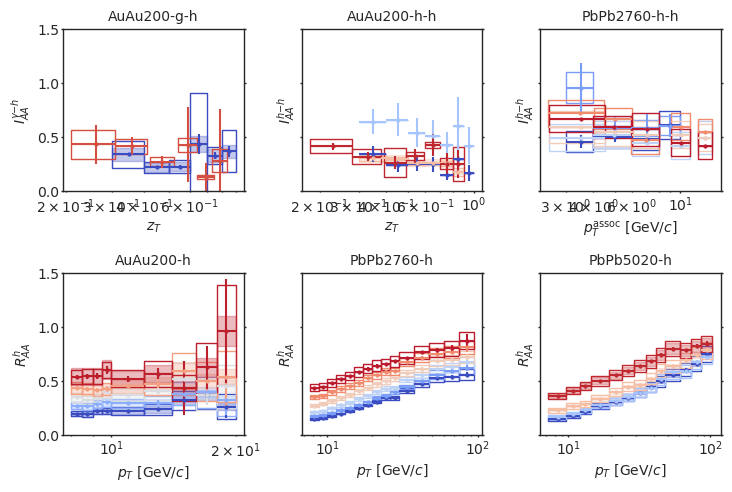

In [144]:
# plot exp data
# plot the input of a certain design:
panel_szie = 2.5
fig, axes = plt.subplots(2, 3, 
                        figsize=(3*panel_szie,2*panel_szie),
                        sharey=True)
il = 0
for exp, ax in zip(Obs, np.atleast_2d(axes).flatten()):
    
    for i, key in enumerate(keys[exp]):
        color = plt.cm.coolwarm(i/(len(keys[exp])-.9))
        x = exp_x[exp][key]
        xl = exp_xl[exp][key]
        xh = exp_xh[exp][key]
        y = exp_y[exp][key]
        stat = exp_stat[exp][key]
        sys = exp_sys[exp][key]
        sys2 = exp_sys2[exp][key]
        il+=len(y)
        plot_exp(ax, x, xl, xh, y, stat, sys, sys2, c=color)
        
    ax.semilogx()
    ax.set_title(exp)
    ax.set_ylim(0,1.5)
    ax.set_ylabel(ylabels[exp])
    ax.set_xlabel(xlabels[exp])
 
save_fig("2_Exp")

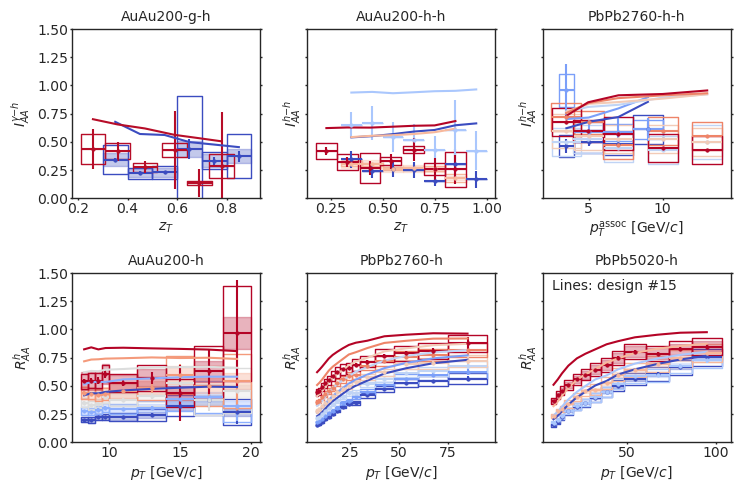

In [145]:
# one set of calculations on a single design point versus exp data
# Let's check design #15
icheck = 15

# plot the input of a certain design:
panel_szie = 2.5
fig, axes = plt.subplots(2, 3, 
                        figsize=(3*panel_szie,2*panel_szie),
                        sharey=True)

axes = np.atleast_1d(axes)
for exp, ax in zip(Obs, axes.flatten()):
    for i, key in enumerate(keys[exp]):
        color = plt.cm.coolwarm(i/(len(keys[exp])-.99))
        x, y = np.loadtxt(path).T
        x = model_x[icheck][exp][key]
        y = model_y[icheck][exp][key]
        ax.plot(x,y, color=color)

        x = exp_x[exp][key]
        xl = exp_xl[exp][key]
        xh = exp_xh[exp][key]
        y = exp_y[exp][key]
        stat = exp_stat[exp][key]
        sys = exp_sys[exp][key]
        sys2 = exp_sys2[exp][key]
        plot_exp(ax, x, xl, xh, y, stat, sys, sys2, c=color)
        
    #ax.semilogx()
    ax.set_title(exp)
    ax.set_ylim(0,1.5)
    ax.set_ylabel(ylabels[exp])
    ax.set_xlabel(xlabels[exp])
axes.flatten()[-1].annotate("Lines: design #{}".format(icheck), xy=(.05,.9), xycoords="axes fraction")
    
save_fig("3_Exp_vs_single_design")

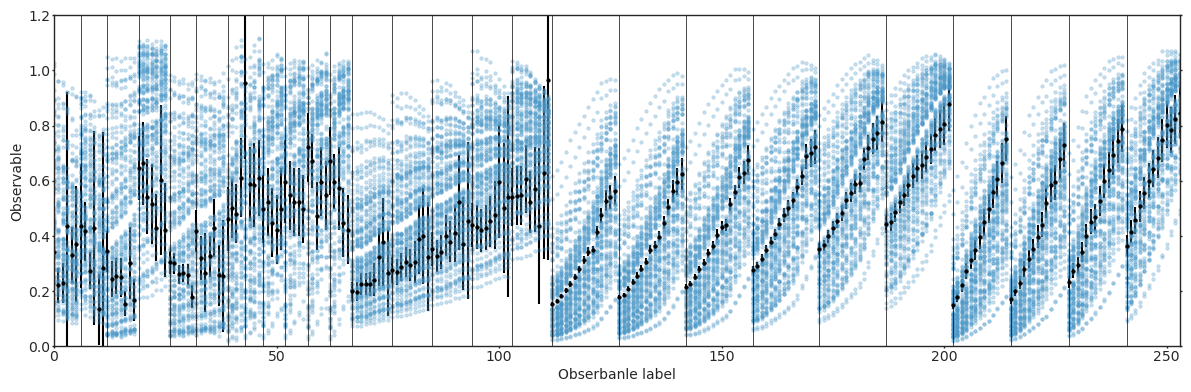

In [151]:
# Now, let check calculations on all design points on 
# plot all calcualtions and concate them to a single Ndesign by M matrix
fig, ax = plt.subplots(1,1,figsize=(2*len(Obs),4))
model_y_c = []
for i in range(Ndesign):
    it = []
    for exp in Obs:
        for key in keys[exp]:
            color = plt.cm.coolwarm(i/len(keys[exp]))
            x = model_x[i][exp][key]
            y = model_y[i][exp][key]
            it.append(y)
    it = np.concatenate(it)
    model_y_c.append(it)
    ax.plot(np.arange(len(it)),it, '.',color=cb, alpha=.3)
model_y_c = np.array(model_y_c)
y_exp = []
# uncorr
y_local = []
for exp in Obs:
    for key in keys[exp]:
        y = exp_y[exp][key]
        stat = exp_stat[exp][key]
        sys = exp_sys[exp][key]
        y_exp.append(y)
        y_local.append(np.sqrt(stat**2+sys**2) )
y_exp = np.concatenate(y_exp)
y_local = np.concatenate(y_local)
y_exp_variance = np.diag(y_local**2) 

# corr
il=0
for exp in Obs:
    for key in keys[exp]:    
        sys2 = exp_sys2[exp][key]
        ih = il+len(sys2)
        ax.plot([ih,ih], [0,1.2], 'k-', lw=.5)
        y_exp_variance[il:ih, il:ih] += np.diag(sys2 * sys2)
        il = np.copy(ih)
        
        
ax.errorbar(np.arange(len(y_exp)), y_exp, yerr=np.diag(y_exp_variance)**.5, fmt='k.')
ax.set_ylim(0,1.2)
ax.set_xlim(0, ih-1)
ax.set_ylabel(r"Observable")
ax.set_xlabel(r"Obserbanle label")
save_fig("4_Exp_vs_all_design")

# Transform the design into feature space
For Gaussian random field we can simply go to the k space where the correlation become diagonal

For non-Gaussian random field:
1. It it is transformed from a Gaussian random field, we can still use the same method.
2. More generally, we can use PCA to generalize the k space into a feature space. If it is a Gaussian random field, the PCA emperical basis will be the same as the k basis. 

In [306]:
Npc=8
# Transform the design into the original space
SS  =  StandardScaler(copy=True)
pca = PCA(copy=True, whiten=True, svd_solver='full')
# Keep only the first `npc` principal components
pc_param_data = pca.fit_transform(SS.fit_transform(np.log(design))) [:,:Npc]

# The transformation matrix from PC to Physical space
inverse_param_matrix = pca.components_ * np.sqrt(pca.explained_variance_[:, np.newaxis]) * SS.scale_ 
inverse_param_matrix = inverse_param_matrix[:Npc,:] # Z --> [Nch, v2]

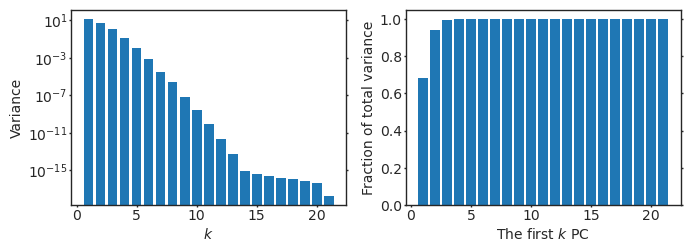

In [307]:
#### Block 14 #### Please refer to this number in your questions
# print the explained raito of variance
fig, (ax1, ax2) = plt.subplots(1,2,figsize=(7,2.6))
#importance = pca_analysis.explained_variance_
importance = pca.explained_variance_
cumulateive_importance = np.cumsum(importance)/np.sum(importance)
idx = np.arange(1,1+len(importance))
ax1.bar(idx,importance)
ax1.semilogy()
ax1.set_xlabel("$k$")
ax1.set_ylabel("Variance")
ax2.bar(idx,cumulateive_importance)
ax2.set_xlabel(r"The first $k$ PC")
ax2.set_ylabel("Fraction of total variance")
save_fig("5_Deign_in_k_space")

# Tranform the observable into the feature space using PCA

In [308]:
UsePC = [0,1,2,3,4]
Npc2 = len(UsePC)
# Transform the design into the original space
SS2  =  StandardScaler(copy=True)
pca2 = PCA(copy=True, whiten=True, svd_solver='full')
# Keep only the first `npc` principal components
pc_model_data = pca2.fit_transform(SS2.fit_transform(model_y_c)) [:,UsePC]

# The transformation matrix from PC to Physical space
inverse_model_matrix = pca2.components_ * np.sqrt(pca2.explained_variance_[:, np.newaxis]) * SS2.scale_ 
inverse_model_matrix = inverse_model_matrix[UsePC,:] # Z --> [Nch, v2]
print(inverse_model_matrix.shape)

(5, 254)


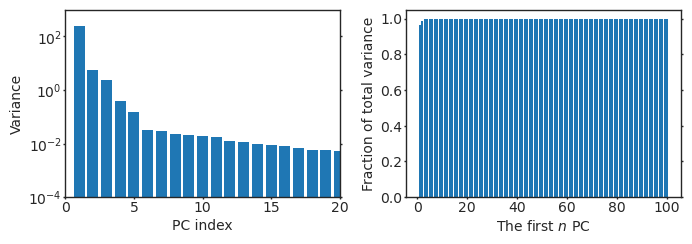

In [309]:
fig, (ax1, ax2) = plt.subplots(1,2,figsize=(7,2.6))
#importance = pca_analysis.explained_variance_
importance = pca2.explained_variance_
cumulateive_importance = np.cumsum(importance)/np.sum(importance)
idx = np.arange(1,1+len(importance))
ax1.bar(idx,importance)
ax1.semilogy()
ax1.set_xlabel("PC index")
ax1.set_ylabel("Variance")
ax1.set_xlim(0,20)
ax1.set_ylim(1e-4,1e3)
ax2.bar(idx,cumulateive_importance)
ax2.set_xlabel(r"The first $n$ PC")
ax2.set_ylabel("Fraction of total variance")
save_fig("6_Obs_in_feature_space")

# The prior region for MCMC in the k-space of the design

In [341]:
DIM = np.copy(Npc)
Boundary = 2.75
Boundary_sq = Boundary**2
design_ptp = np.ones(Npc)*Boundary
# This is to ensure that we only perform MCMC within the region with dense design points, 
# an effective reduction of the prior range

# Training the Gaussian process emulator or load exisiting emulator if overide=False

In [342]:
overide = False
if (os.path.exists(emulator_file)) and (overide==False):
    print('Saved emulators exists and overide is prohibited')
    print("Loading exisintg emulator")
    with open(emulator_file, "rb") as f:
        Emulators=pickle.load(f)
else:
    Emulators = []
    for i, ipc in enumerate(UsePC):
        start_time = time.time()
        kernel = 1*kernels.RBF(length_scale=design_ptp,
                          length_scale_bounds=np.outer(design_ptp, (1e-1, 1e2)))\
               +   kernels.WhiteKernel(noise_level=.1, 
                           noise_level_bounds=(1e-6, 1e4))
        print("-----------------")
        print("Training PC #",i+1)
        GPR = gpr(kernel=kernel,n_restarts_optimizer=50)
        GPR.fit(pc_param_data, pc_model_data[:,i].reshape(-1,1))
        print(GPR.kernel_)
        print('GPR score: {:1.3f}'.format(GPR.score(pc_param_data, pc_model_data[:,i])) )
        print("time: {:1.3f} seconds".format(time.time() - start_time))
        Emulators.append(GPR)
if (overide==True) or not (os.path.exists(emulator_file)):
    with open(emulator_file, "wb") as f:
        print("Saving emulator")
        pickle.dump(Emulators,f)
        
        

-----------------
Training PC # 1
1.24**2 * RBF(length_scale=[2.97, 4.46, 12.6, 50, 82.2, 275, 275, 275]) + WhiteKernel(noise_level=8.96e-06)
GPR score: 1.000
time: 4.012 seconds
-----------------
Training PC # 2
2.26**2 * RBF(length_scale=[2.13, 3.17, 10.6, 39.7, 133, 275, 275, 275]) + WhiteKernel(noise_level=0.00019)
GPR score: 1.000
time: 3.991 seconds
-----------------
Training PC # 3
1.82**2 * RBF(length_scale=[2.43, 2.45, 6.97, 21.9, 41.2, 120, 275, 275]) + WhiteKernel(noise_level=0.0003)
GPR score: 1.000
time: 3.816 seconds
-----------------
Training PC # 4
2.91**2 * RBF(length_scale=[1.49, 2.17, 10.1, 18, 275, 275, 275, 275]) + WhiteKernel(noise_level=0.00944)
GPR score: 0.994
time: 4.470 seconds
-----------------
Training PC # 5
2**2 * RBF(length_scale=[1.43, 1.75, 4.04, 71.6, 275, 275, 275, 189]) + WhiteKernel(noise_level=0.0156)
GPR score: 0.990
time: 5.980 seconds
Saving emulator


# The function to convert an input parameter to prediction + uncertainty
Note that we add an extra standard devitation to account for model imperfection

In [343]:
def predict_observables(theta, extra_std):
    mean = []
    std = []
    for i in range(Npc2):
        mn, s = Emulators[i].predict([theta], return_std=True)
        mean.append(mn[0])
        std.append(s[0])
    mean = np.array(mean)
    variance_matrix = np.diag(np.array(std)**2+extra_std**2)
    inverse_transformed_mean = mean.reshape(-1,Npc2)@inverse_model_matrix + SS2.mean_
    inverse_transformed_variance = np.matmul(np.matmul(inverse_model_matrix.T, variance_matrix), inverse_model_matrix)
    return inverse_transformed_mean[0], inverse_transformed_variance

# Parameters for the prior of the extra model uncertainty

In [344]:
sigma0 = 0.015
sigma_sys_min = 0.001
sigma_sys_max = 0.5

In [345]:
# The prior distribution
def log_prior(X):
    # Prior is drawn in a high-dim sphere in the k-space
    if (X[:-1]**2).sum() > Boundary_sq or X[-1]<sigma_sys_min or X[-1]>sigma_sys_max:
        return -np.inf
    else:
        sigma = X[-1]
        return -.5*(X[:-1]**2).sum() + np.log(sigma) - sigma/sigma0


# The likelihood
def mvn_loglike(y, cov):# y = y_pred - y_exp, cov = exp + emulator
    """
    Evaluate the multivariate-normal log-likelihood for difference vector `y`
    and covariance matrix `cov`:

        log_p = -1/2*[(y^T).(C^-1).y + log(det(C))] + const.

    The likelihood is NOT NORMALIZED, since this does not affect MCMC.  The
    normalization const = -n/2*log(2*pi), where n is the dimensionality.

    Arguments `y` and `cov` MUST be np.arrays with dtype == float64 and shapes
    (n) and (n, n), respectively.  These requirements are NOT CHECKED.

    The calculation follows algorithm 2.1 in Rasmussen and Williams (Gaussian
    Processes for Machine Learning).

    """
    # Compute the Cholesky decomposition of the covariance.
    # Use bare LAPACK function to avoid scipy.linalg wrapper overhead.
    L, info = lapack.dpotrf(cov, clean=False)

    if info < 0:
        raise ValueError(
            'lapack dpotrf error: '
            'the {}-th argument had an illegal value'.format(-info)
        )
    elif info < 0:
        raise np.linalg.LinAlgError(
            'lapack dpotrf error: '
            'the leading minor of order {} is not positive definite'
            .format(info)
        )

    # Solve for alpha = cov^-1.y using the Cholesky decomp.
    alpha, info = lapack.dpotrs(L, y)

    if info != 0:
        raise ValueError(
            'lapack dpotrs error: '
            'the {}-th argument had an illegal value'.format(-info)
         )

    if np.all(L.diagonal()>0):
        return -.5*np.dot(y, alpha) - np.log(L.diagonal()).sum()
    else:
        return -.5*np.dot(y, alpha) - np.log(np.abs(L.diagonal())).sum()
        print(L.diagonal())
        raise ValueError(
            'L has negative values on diagonal {}'.format(L.diagonal())
        )
        
# The posterior distribution
def log_posterior(model_parameters):
    mean, pred_var = predict_observables(model_parameters[:-1], extra_std=model_parameters[-1])
    delta_y = mean - y_exp
    total_var = pred_var + y_exp_variance
    return log_prior(model_parameters) + mvn_loglike(delta_y, total_var)

In [346]:
# MCMC, if True, generate new samples, otherwise load from existing data file
do_mcmc = False

DIM_ = DIM+1
design_min_ = np.array(list(design_min)+[sigma_sys_min])
design_max_ = np.array(list(design_max)+[sigma_sys_max])
ptp_ = design_max_ - design_min_

nwalkers = 20*DIM_  # number of MCMC walkers
nburn = 2000 # "burn-in" period to let chains stabilize
nsteps = 2000  # number of MCMC steps to take


if do_mcmc==True:

    starting_guesses = np.random.normal(0,1,[nwalkers, DIM_])
    starting_guesses[:,-1] = sigma_sys_min + (sigma_sys_max-sigma_sys_min)*np.random.rand(nwalkers)

    print("MCMC sampling using emcee (affine-invariant ensamble sampler) with {0} walkers".format(nwalkers))
    sampler = emcee.EnsembleSampler(nwalkers, DIM_, log_posterior)
    print('burn in sampling started')    
    pos = sampler.run_mcmc(starting_guesses, nburn, progress=True, store=True)
    print("Mean acceptance fraction: {0:.3f} (in total {1} steps)".format(
                    np.mean(sampler.acceptance_fraction), nwalkers*nburn))
    print('Burn in completed.')
    print("Now running the samples")
    sampler.run_mcmc(initial_state=None, nsteps=nsteps, progress=True, tune=False)  
    print("Mean acceptance fraction: {0:.3f} (in total {1} steps)".format(
                    np.mean(sampler.acceptance_fraction), nwalkers*nsteps))

    samples = sampler.get_chain(flat=True, discard=nburn)
    samples_df = pd.DataFrame(samples)
    samples_df.to_csv(StatisticalDataFolder+"/chain.dat", index=False)
else:

    print('Loading chain from disk')
    samples_df=pd.read_csv(StatisticalDataFolder+"/chain.dat")
    samples= samples_df.values
samples_df.head()

  0%|          | 0/2000 [00:00<?, ?it/s]

MCMC sampling using emcee (affine-invariant ensamble sampler) with 180 walkers
burn in sampling started


  0%|          | 0/2000 [00:00<?, ?it/s]

Mean acceptance fraction: 0.274 (in total 360000 steps)
Burn in completed.
Now running the samples


100%|██████████| 2000/2000 [07:59<00:00,  3.73it/s]


Mean acceptance fraction: 0.271 (in total 360000 steps)


0         1         2         3         4         5         6  \
0 -1.187762  1.490011 -1.350276 -0.515527 -0.454056 -0.768821 -0.658680   
1 -0.425238  1.493456 -1.376901  0.528772 -0.188455  0.338256  1.309271   
2 -1.292955  1.617195 -1.399833  0.635034 -0.165942 -0.099966  0.170912   
3 -1.312089  1.577284 -0.759846 -0.335679 -0.198214 -0.663644 -0.544730   
4 -1.212753  1.822040 -1.270589  0.179608  0.526441 -0.457907  0.124633   

          7         8  
0  0.220740  0.263275  
1  0.333470  0.213119  
2  0.062499  0.216959  
3 -1.145300  0.242534  
4  0.303720  0.228670

# Plot the posterior distribution in the k-space

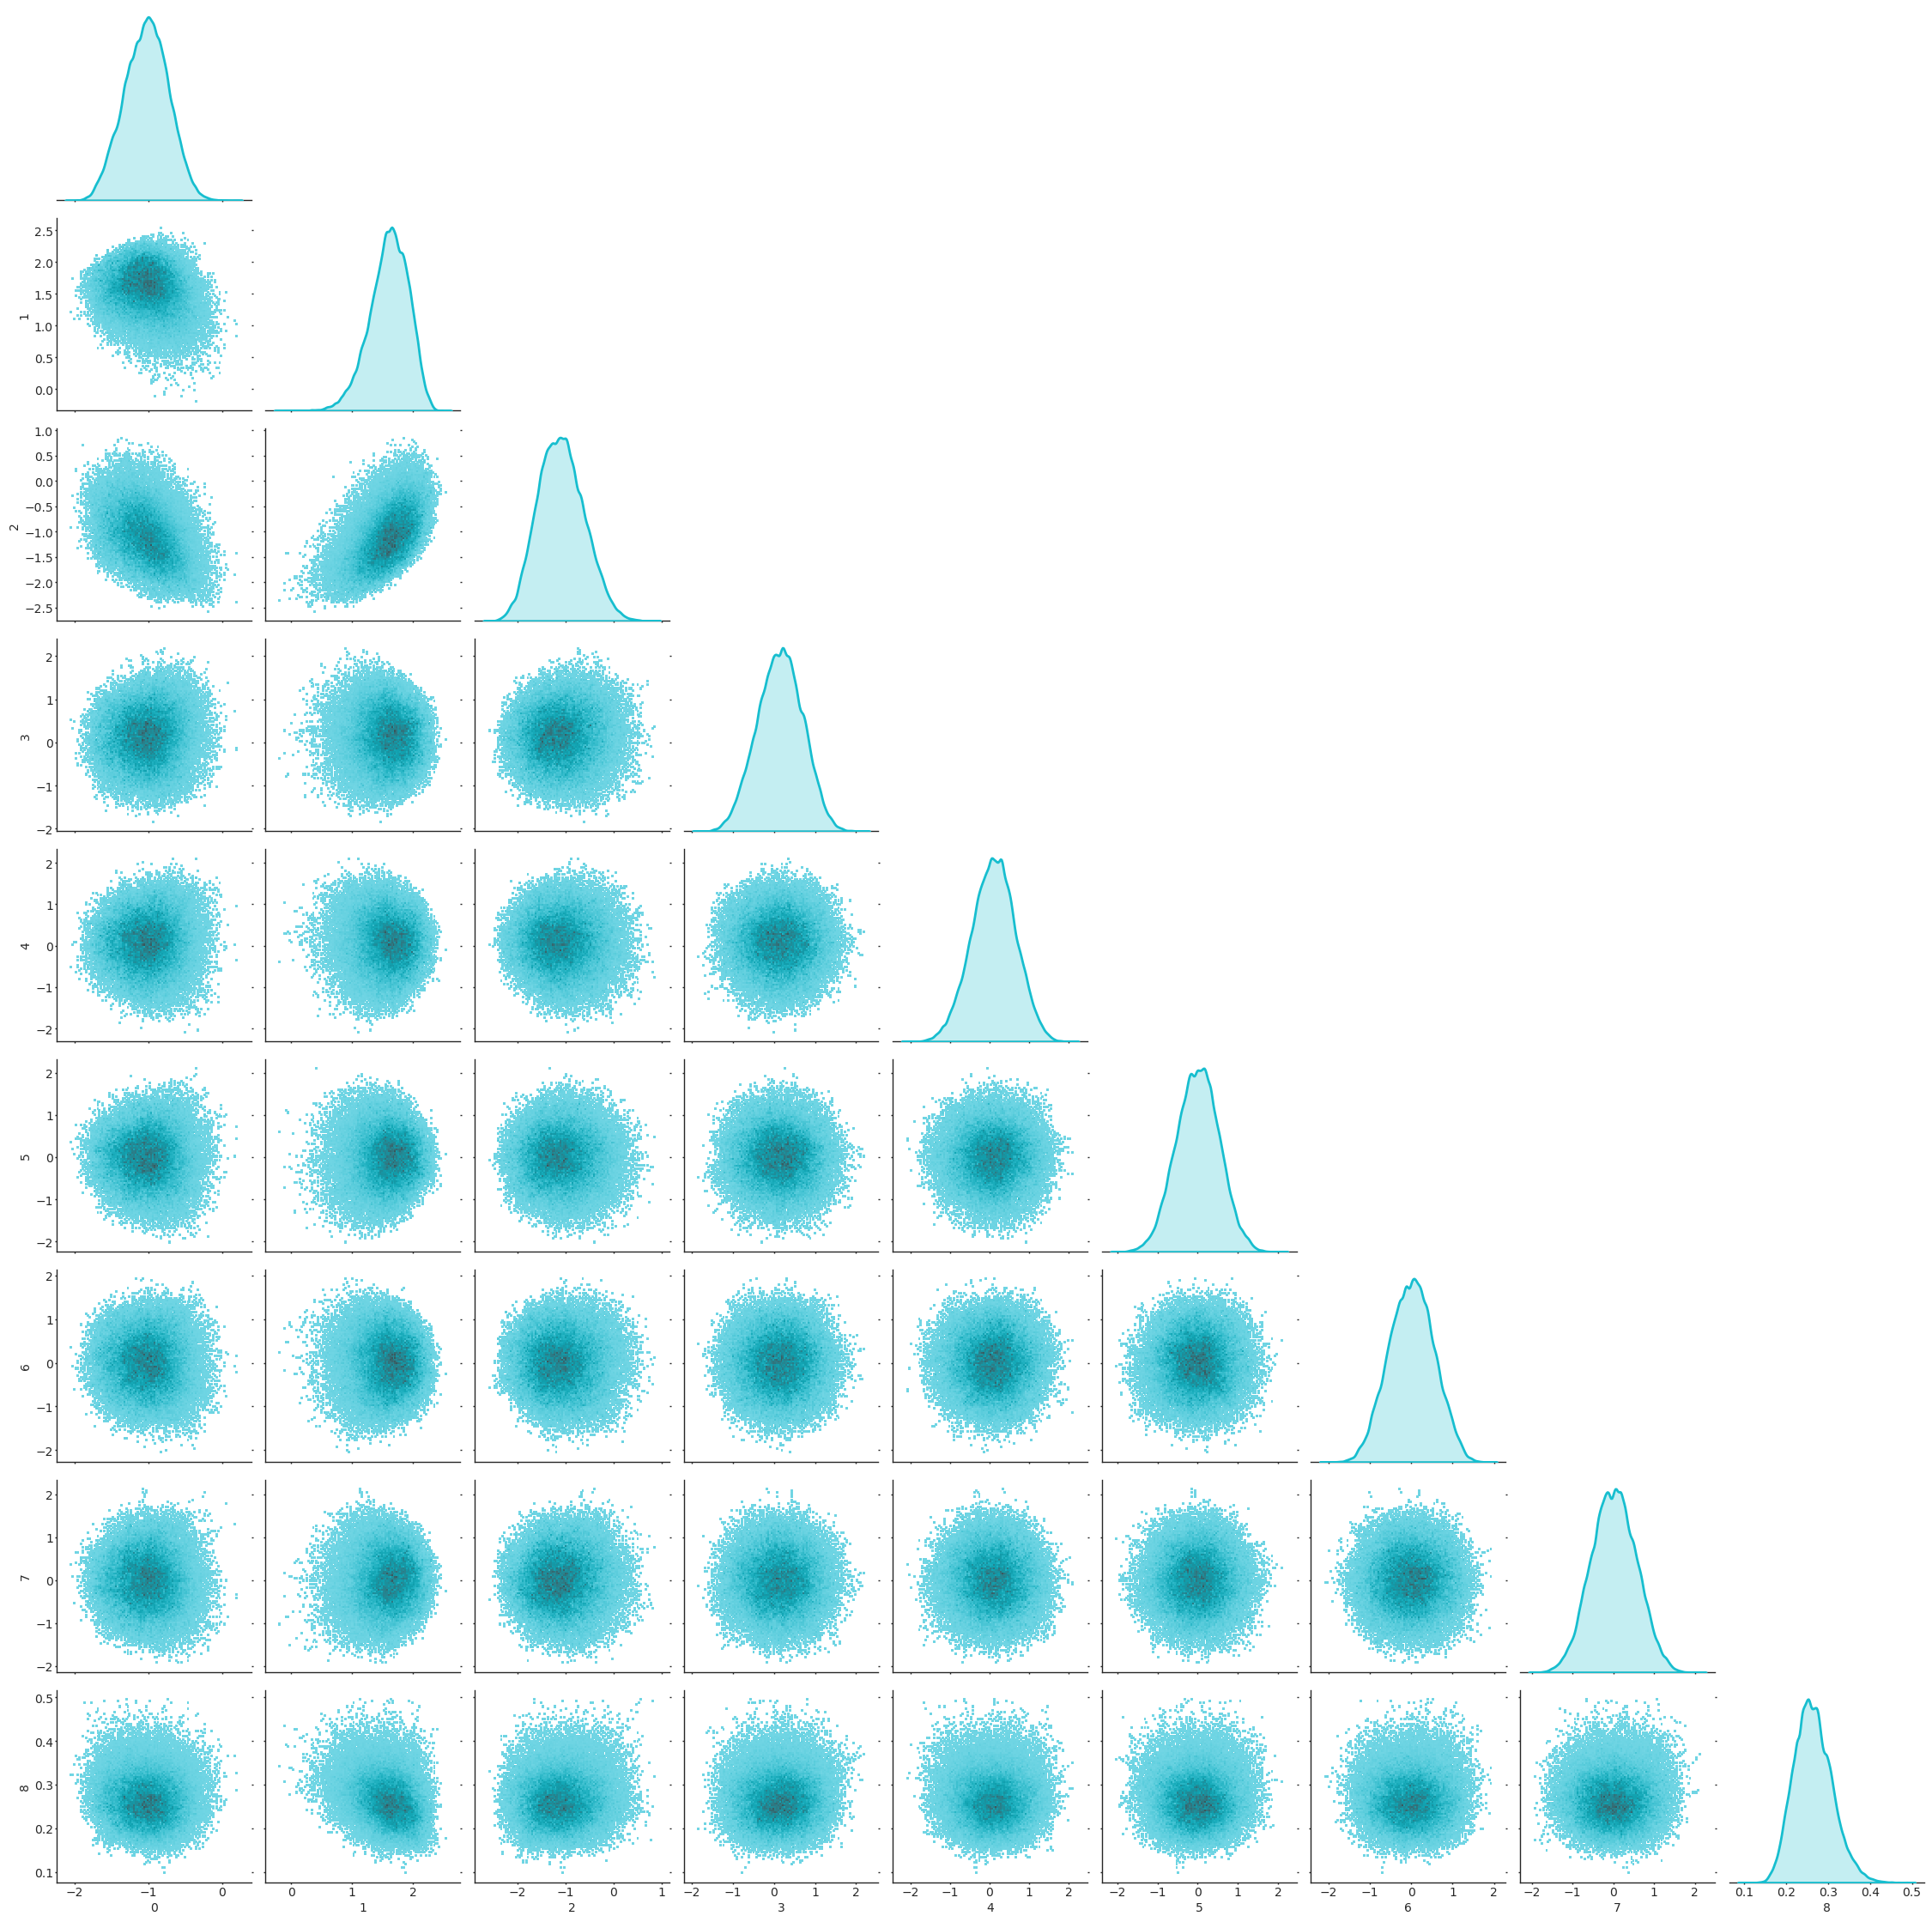

In [347]:
#### Block 25 #### Please refer to this number in your questions
g = sns.PairGrid(samples_df.iloc[:,:], corner=True, diag_sharey=False)
g.map_lower(sns.histplot, bins=100, color=sns.color_palette()[9])
g.map_diag(sns.kdeplot, linewidth=2, shade=True, color=sns.color_palette()[-1])
plt.tight_layout()


# Functions to transform back and forth between qhat/T3(T) and the k-space

In [350]:
def PC2qhatT3(p):
    res = p @ inverse_param_matrix + SS.mean_
    return np.exp(res)
def qhat2PC(qhat):
    lnqhat = np.log(qhat)
    return pca.transform(SS.transform(lnqhat))

# Posterior distribution of qhat/T3

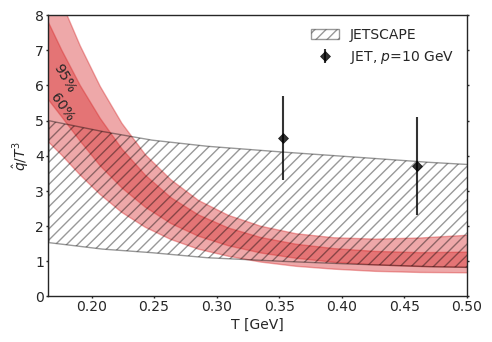

In [351]:
Nsamples = 4000
Nthin = 10

posterior_qhat = np.array([
        PC2qhat(it[:-1]) for it in samples_df.iloc[::Nthin,:].values
])

fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(textwidth/2., textwidth/2*.7), 
                       sharex=False, sharey=False, constrained_layout=True)
CLbins = [60,95]
for CL, opacity in zip(CLbins, [.4,.4]):
    lower, upper = np.percentile(posterior_qhat, [50-CL/2., 50+CL/2.], axis=0)
    ax.fill_between(T,lower, upper,color=sns.color_palette()[3], alpha=opacity)

ax.annotate("60%", xy=(.165,4.99), rotation=-55)
ax.annotate("95%", xy=(.167,5.8), rotation=-60)

y = np.array([4.5, 3.7])
dy = np.array([1.2, 1.4])
x = np.array([.353, .46])
ax.errorbar(x, y, yerr=dy, fmt='kD', label='JET, $p$=10 GeV' , alpha=.8)

Tj, qjl, qjh = np.loadtxt("./JETSCAPE_prelim.dat").T
ax.fill_between(Tj, qjl, qjh, edgecolor='k', facecolor='none', label='JETSCAPE', hatch='///', alpha=.4)

ax.set_ylim(0,8)
ax.set_xlim(.165,.5)
ax.legend(loc='upper right')
ax.set_xlabel('T [GeV]')
ax.set_ylabel('$\hat{q}/T^3$')
save_fig("7_qhat_posterior")

# Compare calibrated emulator prediction to data

In [359]:
Nthin = 100
obs = np.array([predict_observables(it[:-1], it[-1])[0] for it in samples_df.iloc[::Nthin,:].values])

AuAu200-g-h 8-16 0 6
AuAu200-g-h 12-20 6 12
AuAu200-h-h 8-15-c-0-5 12 19
AuAu200-h-h 8-15-c-20-40 19 26
AuAu200-h-h 8-16 26 32
AuAu200-h-h 12-20 32 39
PbPb2760-h-h 8-15 39 43
PbPb2760-h-h 8-16 43 47
PbPb2760-h-h 19.2-24.0 47 52
PbPb2760-h-h 24.0-28.8 52 57
PbPb2760-h-h 28.8-35.2 57 62
PbPb2760-h-h 35.2-48.0 62 67
AuAu200-h 0-10 67 76
AuAu200-h 10-20 76 85
AuAu200-h 20-30 85 94
AuAu200-h 30-40 94 103
AuAu200-h 40-50 103 112
PbPb2760-h 0-5 112 127
PbPb2760-h 5-10 127 142
PbPb2760-h 10-20 142 157
PbPb2760-h 20-30 157 172
PbPb2760-h 30-40 172 187
PbPb2760-h 40-50 187 202
PbPb5020-h 0-5 202 215
PbPb5020-h 5-10 215 228
PbPb5020-h 10-30 228 241
PbPb5020-h 30-50 241 254


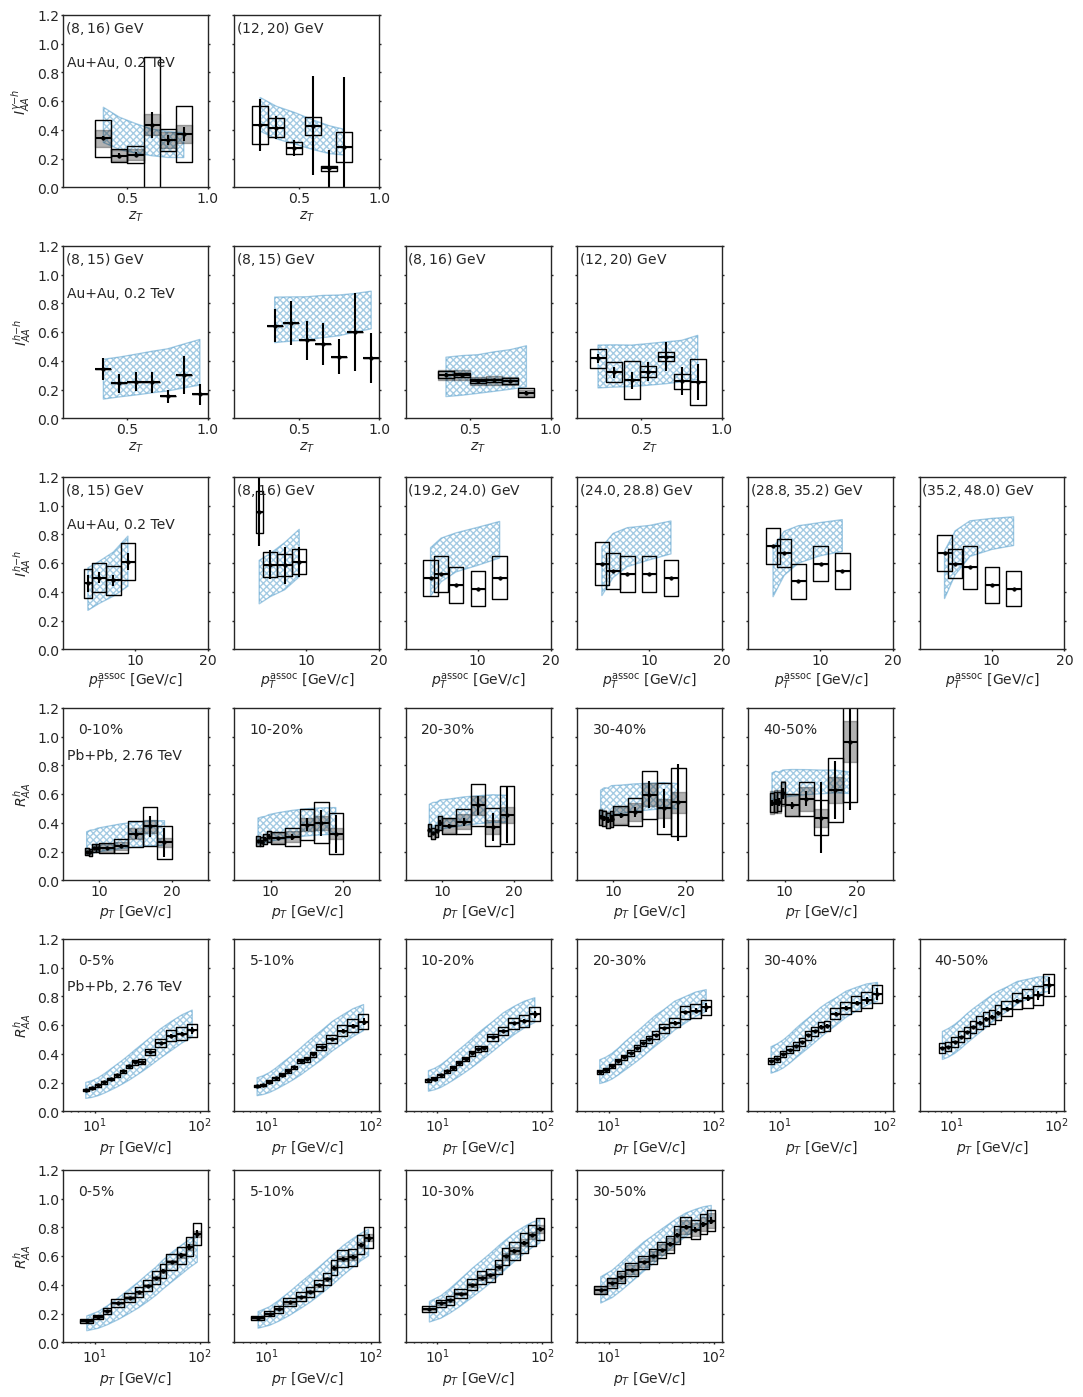

In [363]:
# plot the input of a certain design:
fig, axes = plt.subplots(len(Obs), 6,
                        figsize=(1.1*textwidth, 1.4*textwidth), sharey=True)
axes = np.atleast_2d(axes)
il=0
ih=0
newaxes = [
    axes[0], axes[1],
    axes[2], axes[3], axes[4], axes[5]
]

Xi2 = np.zeros(len(obs))
Npoints = 0
for exp, row in zip(np.atleast_1d(Obs), newaxes):
    for i, (key, ax) in enumerate(zip(keys[exp], row)):
        ing = np.mean(list(map(float, key.split('-')[:2])))/50.
        color = plt.cm.Blues(.6)
        x = exp_x[exp][key]
        xl = exp_xl[exp][key]
        xh = exp_xh[exp][key]
        y = exp_y[exp][key]
        stat = exp_stat[exp][key]
        sys = exp_sys[exp][key] 
        sys2 = exp_sys2[exp][key] 
        ih = il+len(x)
        print(exp, key, il,ih)
        mean = 1#np.average(obs[:,il:ih], axis=0)
        low = np.percentile(obs[:,il:ih], 5, axis=0)
        high = np.percentile(obs[:,il:ih], 95, axis=0)
        ax.fill_between(x, low/mean, high/mean, edgecolor=cb, facecolor='none', hatch='xxxxx', alpha=0.5)

        Xi2[i] += ((obs_map[il:ih]-y)**2/(stat**2+sys**2+sys2**2)).sum()
        Npoints += ih-il
        plot_exp(ax, x, xl, xh, y, stat, sys, sys2, c='k', alpha=0.7, label='Exp.')
        il=np.copy(ih)
        
        if 'h-h' in exp or 'g-h' in exp:
            ax.annotate(r"$({},{})$ GeV".format(*key.split('-')), 
                        xy=(.01,.9), xycoords="axes fraction")
        elif 'AuAu' in exp:
            ax.annotate(r"${}$-${}$%".format(*key.split('-')), xy=(.1,.85),
                        xycoords="axes fraction")
        else:
            ax.annotate(r"${}$-${}$%".format(*key.split('-')), xy=(.1,.85),
                         xycoords="axes fraction")
            ax.semilogx()
        ax.set_ylim(0,1.2)
        ax.set_xlabel(xlabels[exp])
        ax.set_xlim(xlims[exp])
    row[0].set_ylabel(ylabels[exp])
axes[0,0].annotate("Au+Au, 0.2 TeV", xy=(.025,.7), xycoords="axes fraction")
axes[0,3].annotate("Pb+Pb, 5.02 TeV", xy=(.025,.7), xycoords="axes fraction")
axes[2,0].annotate("Au+Au, 0.2 TeV", xy=(.025,.7), xycoords="axes fraction")
axes[3,0].annotate("Pb+Pb, 2.76 TeV", xy=(.025,.7), xycoords="axes fraction")
axes[4,0].annotate("Pb+Pb, 2.76 TeV", xy=(.025,.7), xycoords="axes fraction")
#axes[5,0].annotate("Pb+Pb, 5.02 TeV", xy=(.025,.7), xycoords="axes fraction")
axes[1,0].annotate("Au+Au, 0.2 TeV", xy=(.025,.7), xycoords="axes fraction")

for ax in axes.flatten():
    if not ax.collections: 
        ax.set_visible(False)

save_fig("8_obs_posterior")


# Generated representative parameter sets
In principle, one should propagate the entire posterior distribution through the physical model to perform ensemble model calcualtions. But this is not practical. Instread, we generate a few high-lighilihood, representative parameter sets for model prediction

1. Perform PCA to the posterior distribution to find the new axis
2. Find the 2.5%, 50%, 97.5% point along each axis.
3. The joint median point is the central prediction set (note that this only works for distributions that are well-approximated by multi-variated gaussian, for very non-linear correlations, the joint median point is not gauranteed to be a representative parameter set, and can even be outside the high-likilihood region of the posterior distribuion).
4. The error sets are determined by moving the median point along each PCA axis by +/- 47.5% in the quantile number.

In [364]:
class Standardlization_PCA:
    def __init__(self, data, Npc):
        self.npc = Npc
        self.scaler = StandardScaler(copy=True)
        self.pca = PCA(copy=True, whiten=True, svd_solver='full')

        # Store the first Npc tranformed observables
        self.TransformedObs = self.pca.fit_transform(self.scaler.fit_transform(data))[:,:Npc]
        # Features of each PC
        self.Features = self.pca.components_
        # The transformation matrix from PC to Physical space
        self.TransformationMatrix = (np.sqrt(self.pca.explained_variance_[:Npc])\
                                    * self.pca.components_[:Npc,:].T).T \
                                    * self.scaler.scale_

        A = (np.sqrt(self.pca.explained_variance_[Npc:])\
            * self.pca.components_[Npc:,:].T).T \
            * self.scaler.scale_
        self.ResidualCov = np.dot(A.T*1., A)
        # cumulative sum of the explained variance
        self.CumulativeVariance = np.cumsum(self.pca.explained_variance_ratio_)
    def PC2Obs(self, PCs):
        return np.dot(PCs, self.TransformationMatrix) + self.scaler.mean_
    def PCcov2Obscov(self, PCcov, with_truncation_err=True):
        results = np.matmul(self.TransformationMatrix.T*PCcov, self.TransformationMatrix)
        if with_truncation_err:
            return results+self.ResidualCov
        else:
            return results

Central set -1.041354856755521 1.61344626787773 -1.071091881344335 0.13657226016457663 0.0924136604065733 -0.0017458487009939043 0.005707486897488042 0.00849227997637677
Error sets: 
[[-1.37038222e+00  2.04104157e+00 -3.35144714e-01  1.10839389e-01
  -9.24402955e-03  3.54985812e-02 -2.02168294e-02  1.15934890e-01]
 [-6.39354334e-01  1.09101696e+00 -1.97026070e+00  1.68012283e-01
   2.16617448e-01 -4.72505149e-02  3.73814140e-02 -1.22779433e-01]
 [-1.12441754e+00  1.59142128e+00 -1.16163671e+00 -6.66424290e-01
   3.03839914e-01  6.01428885e-01  3.29021902e-02  1.37327150e-03]
 [-9.54970127e-01  1.63635214e+00 -9.76925762e-01  9.71684240e-01
  -1.27468476e-01 -6.29044243e-01 -2.25748544e-02  1.58960095e-02]
 [-1.07238640e+00  1.61855168e+00 -9.61570609e-01  2.58391179e-01
   8.04605562e-01 -6.91845319e-02 -2.42213697e-01 -7.20932691e-01]
 [-1.00959345e+00  1.60822078e+00 -1.18318908e+00  1.18881749e-02
  -6.36528907e-01  6.72789840e-02  2.59459746e-01  7.55073236e-01]
 [-1.15820265e+00  

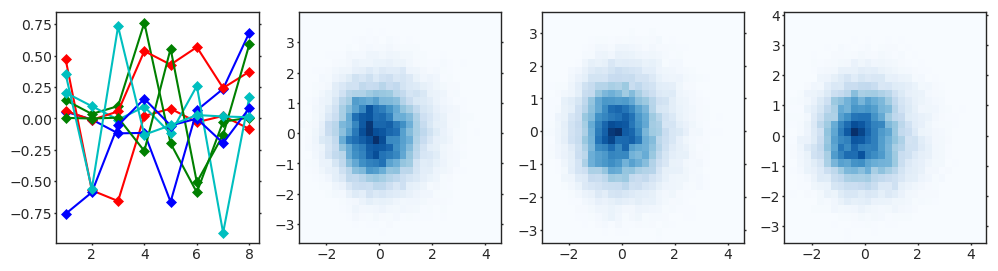

In [396]:
def get_errorsets(samples):
    fig, axes = plt.subplots(1,4,figsize=(12,3))
    ax1, ax2, ax3, ax4 = axes
    Ppc = Standardlization_PCA(samples, Npc=4)
    for i,c in enumerate('rgbcrgbc'):
        ax1.plot([1,2,3,4,5,6,7,8], Ppc.Features[i], c+'D-')
    Z1 = Ppc.TransformedObs[:, 0]
    Z2 = Ppc.TransformedObs[:, 1]
    Z3 = Ppc.TransformedObs[:, 2]
    Z4 = Ppc.TransformedObs[:, 3]
    handle, H, bx, by = ax2.hist2d(Z1, Z2, bins=30)  
    handle, H, bx, by = ax3.hist2d(Z1, Z3, bins=30)
    handle, H, bx, by = ax4.hist2d(Z1, Z4, bins=30)
    dx = 0.05/2
    P0 = np.array([np.median(Z1),np.median(Z2),np.median(Z3),np.median(Z4)])
    P1L = np.array([np.quantile(Z1, dx),np.median(Z2),np.median(Z3),np.median(Z4)])
    P1H = np.array([np.quantile(Z1, 1-dx),np.median(Z2),np.median(Z3),np.median(Z4)])
    P2L = np.array([np.median(Z1),np.quantile(Z2, dx),np.median(Z3),np.median(Z4)])
    P2H = np.array([np.median(Z1),np.quantile(Z2, 1-dx),np.median(Z3),np.median(Z4)])
    P3L = np.array([np.median(Z1),np.median(Z2),np.quantile(Z3, dx),np.median(Z4)])
    P3H = np.array([np.median(Z1),np.median(Z2),np.quantile(Z3,1-dx),np.median(Z4)])
    P4L = np.array([np.median(Z1),np.median(Z2),np.median(Z3),np.quantile(Z4, dx)])
    P4H = np.array([np.median(Z1),np.median(Z2),np.median(Z3),np.quantile(Z4,1-dx)])

    central_set = Ppc.PC2Obs(P0)
    errorset11 = Ppc.PC2Obs(P1L)
    errorset12 = Ppc.PC2Obs(P1H)
    errorset21 = Ppc.PC2Obs(P2L)
    errorset22 = Ppc.PC2Obs(P2H)
    errorset31 = Ppc.PC2Obs(P3L)
    errorset32 = Ppc.PC2Obs(P3H)
    errorset41 = Ppc.PC2Obs(P4L)
    errorset42 = Ppc.PC2Obs(P4H)
    error_set = np.array([errorset11,errorset12,errorset21,errorset22,
                          errorset31,errorset32,errorset41,errorset42])
    return central_set, error_set

central, error = get_errorsets(samples_df.iloc[:,:-1].values)
print("Central set",*central) 
print("Error sets: ")
print(error)         

In [397]:
representative_qhat = np.array([ PC2qhat(it) for it in [central, *error] ])

Plot the represetnative qhatT3 parameter sets versus the full posterior distribution

No handles with labels found to put in legend.


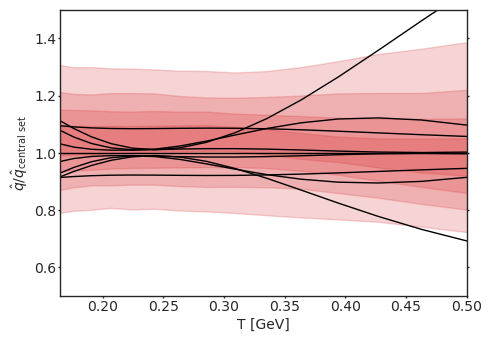

In [398]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(textwidth/2., textwidth/2*.7), 
                       sharex=False, sharey=False, constrained_layout=True)

CLbins = [20,40,60,80]
for CL in CLbins:
    lower, upper = np.percentile(posterior_qhat, [50-CL/2., 50+CL/2.], axis=0)/representative_qhat[0]
    ax.fill_between(T, lower, upper, color=sns.color_palette()[3], alpha=.2)

for it in representative_qhat:
    ax.plot(T, it/representative_qhat[0], '-', color='k', lw=1)

ax.set_ylim(.5,1.5)
ax.set_xlim(.165,.5)
ax.legend(loc='upper right')
ax.set_xlabel('T [GeV]')
ax.set_ylabel(r'$\hat{q}/\hat{q}_{\rm central~set}$')
save_fig("qhat_representative_sets")